El objetivo de este ejercicio es crear un flujo de trabajo claro en el cual podemos recibir un archivo csv, importarlo a una base de datos sql y luego manipularlo en jupyter notebooks para crear reportería de gráficos y mapas.

# SQL - Postgres

Primero, crear una database para trabajar, en este caso 'salarios_mundo'
Ingresar a la database y crear una nueva tabla con los parámetros del csv de trabajo, en este caso ds_salaries del desafio latam

-- Script para psql

-- Crear tabla salaries
DROP TABLE IF EXISTS salaries;

CREATE TABLE salaries (
    work_year INTEGER,
    experience_level VARCHAR(10),
    employment_type VARCHAR(10),
    job_title TEXT,
    salary NUMERIC,
    salary_currency VARCHAR(10),
    salary_in_usd NUMERIC,
    employee_residence VARCHAR(10),
    remote_ratio INTEGER,
    company_location VARCHAR(10),
    company_size VARCHAR(5)
);

-- Importar datos desde CSV
\copy salaries FROM 'C:\Users\Legion\Documents\desafio_latam\Estadistica\Desafio 1\ds_salaries.csv' DELIMITER ',' CSV HEADER;

-- Verificar cantidad de filas cargadas
SELECT COUNT(*) AS total_registros FROM salaries;


# Python


In [5]:
import pandas as pd
import sqlalchemy
import psycopg2

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

# Para graficar en mapas
import geopandas as gpd
import geodatasets

C:\Users\Legion\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Users\Legion\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\Users\Legion\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [6]:
from sqlalchemy import create_engine

#Completar los datos necesarios para conectar la database de postgres
usuario = "postgres"
contraseña = "postgres"  
host = "localhost"
puerto = "5432"
base_datos = "salarios_mundo"

# Crear el engine de conexión
engine = create_engine(f"postgresql://{usuario}:{contraseña}@{host}:{puerto}/{base_datos}")


Creamos una funcion para poder leer las tablas de SQL como un dataframe

In [8]:
def leer_tabla(tabla, engine):
    """
    Lee una tabla completa desde PostgreSQL y la devuelve como DataFrame de pandas.
    """
    query = f"SELECT * FROM {tabla};"
    return pd.read_sql(query, engine)

In [9]:
# Creamos el nuevo data frame a partir de la tabla SQL
salarios = leer_tabla('salaries', engine)

In [10]:
salarios


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000.0,EUR,85847.0,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000.0,USD,30000.0,US,100,US,S
2,2023,MI,CT,ML Engineer,25500.0,USD,25500.0,US,100,US,S
3,2023,SE,FT,Data Scientist,175000.0,USD,175000.0,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000.0,USD,120000.0,CA,100,CA,M
...,...,...,...,...,...,...,...,...,...,...,...
3750,2020,SE,FT,Data Scientist,412000.0,USD,412000.0,US,100,US,L
3751,2021,MI,FT,Principal Data Scientist,151000.0,USD,151000.0,US,100,US,L
3752,2020,EN,FT,Data Scientist,105000.0,USD,105000.0,US,100,US,S
3753,2020,EN,CT,Business Data Analyst,100000.0,USD,100000.0,US,100,US,L


In [11]:
salarios.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   work_year           3755 non-null   int64  
 1   experience_level    3755 non-null   object 
 2   employment_type     3755 non-null   object 
 3   job_title           3755 non-null   object 
 4   salary              3755 non-null   float64
 5   salary_currency     3755 non-null   object 
 6   salary_in_usd       3755 non-null   float64
 7   employee_residence  3755 non-null   object 
 8   remote_ratio        3755 non-null   int64  
 9   company_location    3755 non-null   object 
 10  company_size        3755 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 322.8+ KB


El conjunto de datos contiene un informe salarial fabricado en el que puedes realizar análisis
para tratar de estimar el salario basado en las condiciones dadas. Las columnas son las
siguientes:\
● work_year: El año en que se pagó el salario. \
● experience_level: El nivel de experiencia en el trabajo durante el año, con los
siguientes valores posibles: EN (nivel de entrada / junior), MI (nivel medio /
intermedio), SE (nivel senior / experto), EX (nivel ejecutivo / director).\
● employment_type: El tipo de empleo para el puesto: PT (tiempo parcial), FT (tiempo
completo), CT (contrato), FL (trabajo freelance).\
● job_title: El puesto de trabajo desempeñado durante el año.\
● salary: El monto total del salario bruto pagado.\
● salary_currency: La moneda en la que se pagó el salario, utilizando un código de
moneda ISO 4217.\
● salary_in_usd: El salario en USD (tipo de cambio dividido por la tasa promedio de
USD para el año correspondiente a través de fxdata.foorilla.com).\
● employee_residence: El país de residencia principal del empleado durante el año
laboral, utilizando un código de país ISO 3166.\
● remote_ratio: La cantidad total de trabajo realizado de forma remota, con los
siguientes valores posibles: 0 (sin trabajo remoto, menos del 20%), 50 (parcialmente
remoto), 100 (totalmente remoto, más del 80%).\
● company_location: El país de la oficina principal del empleador o sucursal
contratante, utilizando un código de país ISO 3166.\

### 3. ¿Qué cargos reciben mejores sueldos en las empresas con sede en Estados Unidos?

In [14]:
# Filtramos empresas en Estados Unidos
sal_us = salarios[salarios['company_location'] == 'US']

# Creamos tabla pivote para ver las medidas de tendencia central de los empleos
pivot_us = pd.pivot_table(
    sal_us,
    values='salary_in_usd',
    index='job_title',
    aggfunc=['mean', 'median']
)

# Orden descendente
pivot_us = pivot_us.sort_values(('mean','salary_in_usd'), ascending=False)

# Mostrar los 10 cargos mejor pagados en US
pivot_us.head(10)

,mean,median
,salary_in_usd,salary_in_usd
job_title,,
Data Analytics Lead,405000.000000,405000.0
Data Science Tech Lead,375000.000000,375000.0
Director of Data Science,294375.000000,287500.0
Principal Data Scientist,255500.000000,227500.0
Cloud Data Architect,250000.000000,250000.0
Applied Data Scientist,238000.000000,177000.0
Head of Data,233183.333333,220000.0
Machine Learning Software Engineer,217400.000000,180000.0


In [15]:
pivot_us.columns
# Las tablas pivote crean columnas multinivel

MultiIndex([(  'mean', 'salary_in_usd'),
            ('median', 'salary_in_usd')],
           )

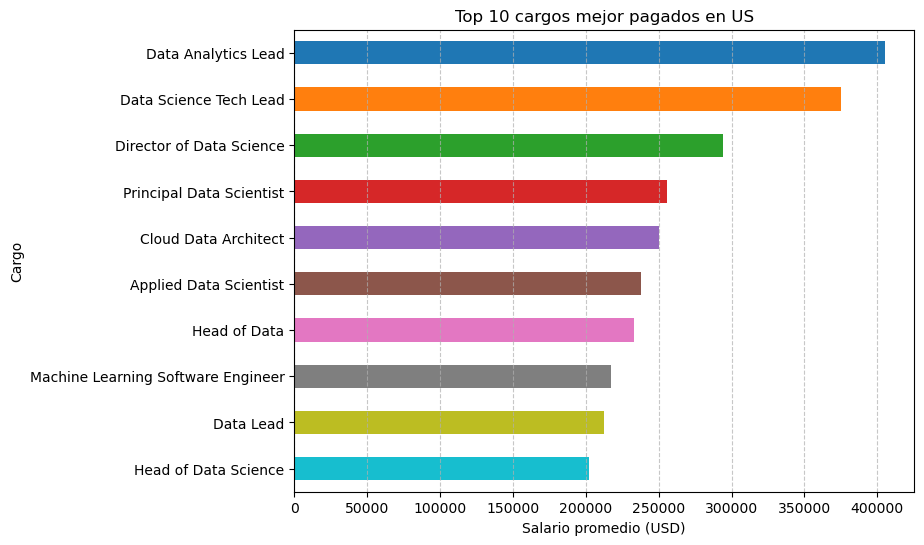

In [16]:
#Seleccionamos solo los top 10 cargos
top10 = pivot_us.head(10)

colors = plt.cm.tab10.colors  # paleta de 10 colores distintos

# Seleccionamos solo la columna 'mean' para graficar y Crear gráfico de barras horizontales
top10[('mean', 'salary_in_usd')].plot(
    kind='barh',
    figsize=(8, 6),
    color=colors,
    legend=False
)

plt.gca().invert_yaxis()  # para que el más alto quede arriba
plt.xlabel("Salario promedio (USD)")
plt.ylabel("Cargo")
plt.title("Top 10 cargos mejor pagados en US")

# Líneas de referencia en el eje X
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()


## Cuales son los paises con el mejor saldo promedio para roles principiantes?

experience_level    EN
company_location
salary_in_usd

necesito filtrar los de experiencia EN
hacer una tabla pivote para sacar el promedio de todos los empleos de cada país




In [19]:
# Filtramos los cargos de nivel principiante
entry_level = salarios[salarios['experience_level'] == 'EN']

#Creamos tabla pivote para mostrar los salarios promedio por pais
pivot_entry = pd.pivot_table(
    entry_level,
    values='salary_in_usd',
    index='company_location',
    aggfunc=['mean']
)

# Orden descendente
pivot_entry = pivot_entry.sort_values(('mean','salary_in_usd'), ascending=False)

In [20]:
pivot_entry.head(10)

,mean
,salary_in_usd
company_location,
BA,120000.000000
SE,105000.000000
US,102400.639344
CN,100000.000000
IR,100000.000000
DZ,100000.000000
IQ,100000.000000
CA,76605.571429


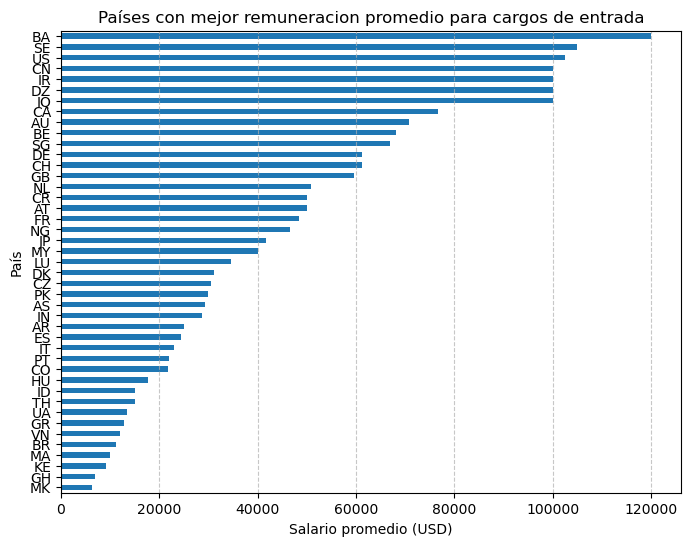

In [21]:
# Seleccionamos solo la columna 'mean' para graficar y Crear gráfico de barras horizontales
pivot_entry[('mean', 'salary_in_usd')].plot(
    kind='barh',
    figsize=(8, 6),
    legend=False
)

plt.gca().invert_yaxis()  # para que el más alto quede arriba
plt.xlabel("Salario promedio (USD)")
plt.ylabel("País")
plt.title("Países con mejor remuneracion promedio para cargos de entrada")

# Líneas de referencia en el eje X
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()


Descargo dataset de mapa del mundo como geojson del siguiente link:
https://public.opendatasoft.com/explore/dataset/world-administrative-boundaries-countries/export/

In [63]:
path = r"C:\Users\Legion\Documents\desafio_latam\Estadistica\Desafio_1\world-administrative-boundaries-countries.geojson"

world = gpd.read_file(path)
# Revisar columnas disponibles
print(world.columns)

Index(['geo_point_2d', 'iso3_code', 'iso2_code', 'preferred_term',
       'english_short', 'french_short', 'spanish_short', 'russian_short',
       'chinese_short', 'arabic_short', 'region_code', 'region_name',
       'sub_region_code', 'sub_region_name', 'geometry'],
      dtype='object')


In [65]:
# Creamos una nueva tabla pivote pero con la funcion de groupby
pivot_entry2 = salarios.groupby('company_location')['salary_in_usd'].mean().reset_index()
pivot_entry2.columns = ['iso2', 'mean_salary_usd']  # cambiamos nombre columna - iso2 = código país ISO-2


Falta corroborar que se haya hecho bien la union (ej paises mal escritos que no se hayan unido)

In [67]:
pivot_entry2


,iso2,mean_salary_usd
0,AE,100000.000000
1,AL,10000.000000
2,AM,50000.000000
3,AR,25000.000000
4,AS,29351.000000
...,...,...
67,TH,23064.333333
68,TR,19058.000000
69,UA,57850.000000
70,US,151822.009539


In [71]:
# Asegurar que ambos sean strings
world['iso2_code'] = world['iso2_code'].astype(str)
pivot_entry2['iso2'] = pivot_entry2['iso2'].astype(str)

# Merge
world_merged = world.merge(
    pivot_entry2,
    how="left",
    left_on="iso2_code",
    right_on="iso2"
)

# Verificar
world_merged.head()


,geo_point_2d,iso3_code,iso2_code,preferred_term,english_short,french_short,spanish_short,russian_short,chinese_short,arabic_short,region_code,region_name,sub_region_code,sub_region_name,geometry,iso2,mean_salary_usd
0,"{ ""lon"": 103.9624562399004, ""lat"": 36.52338912...",CHN,CN,China,China,Chine (la),China,Китай,中国,الصين,142,Asia,30,Eastern Asia,"MULTIPOLYGON (((110.71583 20.06888, 110.77859 ...",CN,100000.000000
1,"{ ""lon"": 25.527616312014302, ""lat"": 58.6741359...",EST,EE,Estonia,Estonia,Estonie (l') [fém.],Estonia,Эстония,爱沙尼亚,إستونيا,150,Europe,154,Northern Europe,"MULTIPOLYGON (((22.98485 58.59944, 23.09083 58...",EE,47416.000000
2,"{ ""lon"": 15.224293438732643, ""lat"": -0.8402315...",COG,CG,Congo,Congo Republic,Congo (le),Congo (el),Конго,刚果,الكونغو,2,Africa,202,Sub-Saharan Africa,"MULTIPOLYGON (((18.62496 3.47944, 18.63236 3.4...",NaN,NaN
3,"{ ""lon"": -8.150578960214073, ""lat"": 53.1763816...",IRL,IE,Ireland,Ireland,Irlande (l') [fém.],Irlanda,Ирландия,爱尔兰,آيرلندا,150,Europe,154,Northern Europe,"MULTIPOLYGON (((-9.97014 54.02083, -9.93833 53...",IE,114943.428571
4,"{ ""lon"": 35.551421918377613, ""lat"": -17.259323...",MOZ,MZ,Mozambique,Mozambique,Mozambique (le),Mozambique,Мозамбик,莫桑比克,موزامبيق,2,Africa,202,Sub-Saharan Africa,"MULTIPOLYGON (((32.89043 -26.84714, 32.76778 -...",NaN,NaN


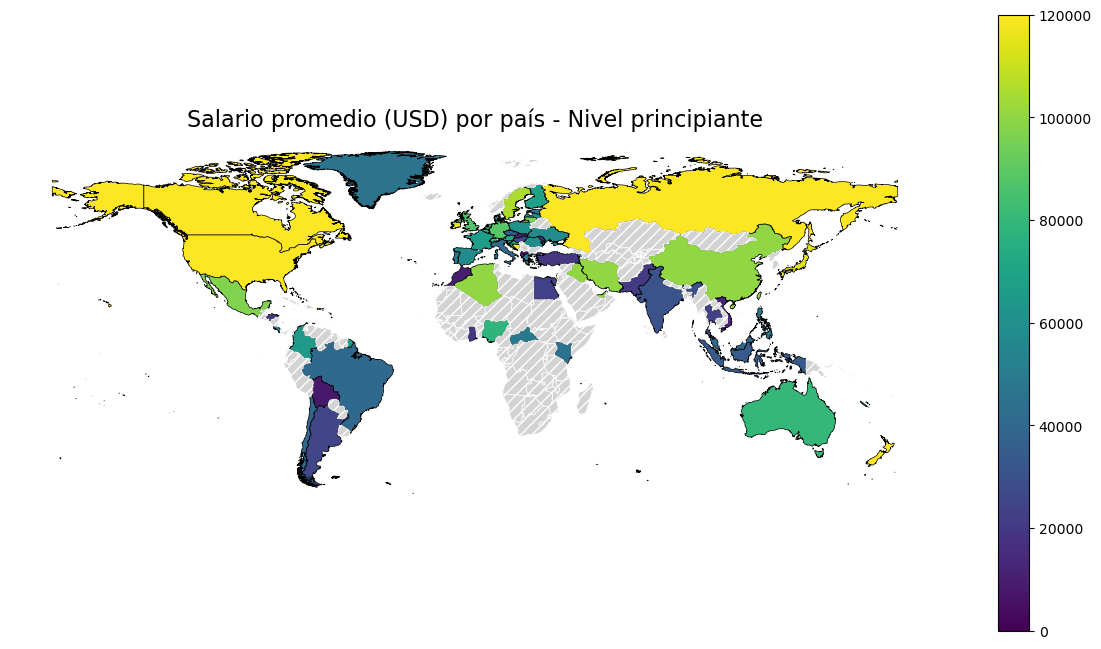

In [77]:

fig, ax = plt.subplots(1, 1, figsize=(15, 8))

world_merged.plot(
    column='mean_salary_usd',
    cmap='viridis',          # color map
    linewidth=0.5,
    ax=ax,
    edgecolor='black',
    legend=True,
     vmin=0,           # mínimo de la rampa
    vmax=120000,      # máximo de la rampa (tope)
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "white",
        "hatch": "///",
        "label": "Sin datos"
    }
)

ax.set_title("Salario promedio (USD) por país - Nivel principiante", fontsize=16)
ax.set_axis_off()

plt.show()
